In [1]:
import sys, os
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join
import h5py
import warnings
import gc

import scmomat 

plt.rcParams["font.size"] = 10

In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_h5(path):
    with h5py.File(path, 'r') as f:
        print(f['matrix'].keys())
        print(f['matrix']['features'].keys())

        barcodes = [_.decode('utf-8') for _ in f['matrix']['barcodes'][:]]
        data = f['matrix']['data'][:]
        indices = f['matrix']['indices'][:]
        indptr = f['matrix']['indptr'][:]
        shape = f['matrix']['shape'][:]

        feature_type = [_.decode('utf-8') for _ in f['matrix']['features']['feature_type'][:]]
        feature_id   = [_.decode('utf-8') for _ in f['matrix']['features']['id'][:]]
        feature_name = [_.decode('utf-8') for _ in f['matrix']['features']['name'][:]]
        feature_interval = [_.decode('utf-8') for _ in f['matrix']['features']['interval'][:]]


        X = sps.csc_matrix(
            (data, indices, indptr), 
            shape = shape
        ).tocsc().astype(np.float32).T.toarray()

        adata = sc.AnnData(X)
        adata.obs_names = barcodes
        adata.var_names = feature_id
        adata.var['type'] = feature_type
        adata.var['name'] = feature_name
        adata.var['interval'] = feature_interval
    return adata

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2


In [3]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

### load dataset

In [4]:
data_dir = '/disco_500t/xuhua/data/MISAR_seq/'
ad_bridge = load_h5(join(data_dir, 'E15_5-S1_raw_feature_bc_matrix.h5'))
ad_test1 = load_h5(join(data_dir, 'E18_5-S1_raw_feature_bc_matrix.h5'))
ad_test2 = load_h5(join(data_dir, 'E18_5-S1_raw_feature_bc_matrix.h5'))  # inconsistent peak name across batches
peak_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'BaiduDisk/section1/peak_mat.mtx')).T)
peak_spot_name = pd.read_csv(join(data_dir, 'BaiduDisk/section1/peak_spot_names.csv')).x.values

meta = pd.read_csv(join(data_dir, 'BaiduDisk/section1/meta_data.csv'), index_col=0)

ad_bridge.obs_names = [f'E15_5-S1#{_}' for _ in ad_bridge.obs_names]
ad_test1.obs_names = [f'E18_5-S1#{_}' for _ in ad_test1.obs_names]
ad_test2.obs_names = [f'E18_5-S1#{_}' for _ in ad_test2.obs_names]

# split rna and peak
ad_bridge_rna = ad_bridge[:, ad_bridge.var['type'] == 'Gene Expression'].copy()
ad_test1_rna = ad_test1[:, ad_test1.var['type'] == 'Gene Expression'].copy()

# subset peak matrices
bridge_mask = np.in1d(peak_spot_name, ad_bridge.obs_names)
ad_bridge_atac = sc.AnnData(peak_mat[bridge_mask])
ad_bridge_atac.obs_names = peak_spot_name[bridge_mask]
test2_mask = np.in1d(peak_spot_name, ad_test2.obs_names)
ad_test2_atac = sc.AnnData(peak_mat[test2_mask])
ad_test2_atac.obs_names = peak_spot_name[test2_mask]

ad_bridge_rna = subset_ad(ad_bridge_rna, ad_bridge_rna.obs_names.intersection(meta.index))
ad_test1_rna = subset_ad(ad_test1_rna, ad_test1_rna.obs_names.intersection(meta.index))

ad_bridge_rna.obs = meta.loc[ad_bridge_rna.obs_names].copy()
ad_bridge_atac.obs = meta.loc[ad_bridge_atac.obs_names].copy()
ad_test1_rna.obs = meta.loc[ad_test1_rna.obs_names].copy()
ad_test2_atac.obs = meta.loc[ad_test2_atac.obs_names].copy()
ad_bridge_rna = set_spatial(ad_bridge_rna)
ad_bridge_atac = set_spatial(ad_bridge_atac)
ad_test1_rna = set_spatial(ad_test1_rna)
ad_test2_atac = set_spatial(ad_test2_atac)

set_col2cat(ad_bridge_rna, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_bridge_atac, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_test1_rna, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_test2_atac, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])

del peak_mat, ad_bridge, ad_test1, ad_test2
gc.collect()

<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>
<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>
<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>


/tmp/ipykernel_52790/645333859.py:20: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad_bridge_atac = sc.AnnData(peak_mat[bridge_mask])
/tmp/ipykernel_52790/645333859.py:23: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad_test2_atac = sc.AnnData(peak_mat[test2_mask])


429

In [5]:
ad_bridge_atac = ad_bridge_atac[ad_bridge_rna.obs_names].copy()
assert (ad_bridge_rna.obs_names == ad_bridge_atac.obs_names).all()

ad_test2_atac = ad_test2_atac[ad_test1_rna.obs_names].copy()
print((ad_test1_rna.obs_names == ad_test2_atac.obs_names).all())

ad_test1_rna.obs_names = [f'rna_{_}' for _ in ad_test1_rna.obs_names]
ad_test2_atac.obs_names = [f'atac_{_}' for _ in ad_test2_atac.obs_names]

ad_bridge_rna.obs['src'] = ad_bridge_atac.obs['src'] = ['s1']*ad_bridge_rna.n_obs
ad_test1_rna.obs['src'] = ['s2-rna']*ad_test1_rna.n_obs
ad_test2_atac.obs['src'] = ['s2-atac']*ad_test2_atac.n_obs
ad_test1_rna.obs['Sample'] = ['S2']*ad_test1_rna.n_obs
ad_test2_atac.obs['Sample'] = ['S2']*ad_test2_atac.n_obs

True


In [6]:
ad_rna_all = sc.concat([ad_bridge_rna, ad_test1_rna])
ad_atac_all = sc.concat([ad_bridge_atac, ad_test2_atac])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='Sample')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

In [7]:
# ac.pp.tfidf(ad_atac_all, scale_factor=1e4)
sc.pp.highly_variable_genes(ad_atac_all, flavor='seurat_v3', n_top_genes=50000, batch_key='Sample')

hvp_names = ad_atac_all.var.query('highly_variable').index.to_numpy()

### prepare count inputs

In [8]:
# READ IN THE COUNT MATRICES
counts_rnas = []
for adi in [ad_bridge_rna, ad_test1_rna, None]:
    if adi is not None:
        count = scmomat.preprocess(adi[:, hvg_names].X, modality = "RNA", log = False)
        counts_rnas.append(count)
    else:
        counts_rnas.append(None)

counts_atacs = []
for adi in [ad_bridge_atac, None, ad_test2_atac]:
    if adi is not None:
        count = scmomat.preprocess(adi[:, hvp_names].X.A, modality = "ATAC", log = False)
        counts_atacs.append(count)
    else:
        counts_atacs.append(None)

In [9]:
# CREATE THE COUNTS OBJECT
n_batches = 3
feats_name = {"rna": hvg_names, "atac": hvp_names}
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "atac": counts_atacs}

### step 2: training scmomat

Input sanity check...
Finished.
Epoch 1, Validating Loss: 122.4026
	 loss reconstruction: 0.11240
	 loss regularization: 1.00000
Epoch 1000, Validating Loss: 87.9480
	 loss reconstruction: 0.08795
	 loss regularization: 0.00016
Epoch 2000, Validating Loss: 86.1671
	 loss reconstruction: 0.08616
	 loss regularization: 0.00026
Epoch 3000, Validating Loss: 85.6452
	 loss reconstruction: 0.08563
	 loss regularization: 0.00110
Epoch 4000, Validating Loss: 85.3756
	 loss reconstruction: 0.08536
	 loss regularization: 0.00107
running time: 403.03607511520386


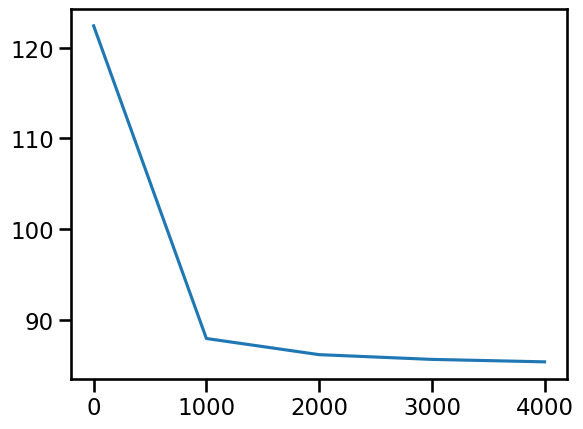

In [10]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 50
lamb = 0.01 
T = 4000     
interval = 1000
batch_size = 0.1
lr = 1e-2
seed = 0
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

#### inference

In [11]:
# umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 

if True:
    zs = model.extract_cell_factors()
    # np.save('./outputs/misar_seq/E15-18-18-zs.npy', zs)
else:
    # zs = np.load('./outputs/misar_seq/E15-18-18-zs.npy', allow_pickle=True)
    pass
# x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

In [12]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
labels = [ad_bridge_rna.obs.Combined_Clusters_annotation, ad_test1_rna.obs.Combined_Clusters_annotation, ad_test2_atac.obs.Combined_Clusters_annotation]
batches = ['bridge']*ad_bridge_rna.shape[0] + ['test-rna']*ad_test1_rna.shape[0] + ['test-atac']*ad_test2_atac.shape[0]

### eval results

In [14]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['annot'] = np.hstack(labels)
ad_mosaic.obs['batches'] = np.hstack(batches)

### before batch corr

In [15]:
ad_test1_rna.obsm['X_emb'] = zs[1]
ad_test2_atac.obsm['X_emb'] = zs[2]

from lisi_bridge import eval_bridge
eval_bridge(
        ad_test1_rna, ad_test2_atac,
        label_key=None,
        batch_key='Sample',
        use_rep='X_emb',
        use_fosc=True, use_acc=False, use_score=True,
    )


FOSCTTM=0.26341
Match_score=0.00686


{'FOSCTTM': 0.26340515386063007, 'Match_score': 0.006858028867749701}

### after batch corr

In [16]:
from batchCorr import HARMONY

ad_mosaic.obsm['X_emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['X_emb']), ad_mosaic.obs['batches'].to_list())
split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obsm', key='X_emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [17]:
r3 = eval_bridge(
        ad_test1_rna, ad_test2_atac,
        label_key=None,
        batch_key='Sample',
        use_rep='X_emb_har',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.24286
Match_score=0.00734


## Vis

In [19]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/misar_seq/E15-18-18_modalMatch/scmomat'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_bridge_rna.obs_names.to_list() + ad_test1_rna.obs_names.to_list() + ad_test2_atac.obs_names.to_list())
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['X_emb_har'], index=ad_bridge_rna.obs_names.to_list() + ad_test1_rna.obs_names.to_list() + ad_test2_atac.obs_names.to_list())
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))

In [20]:
1

1